## Final Project Submission

Please fill out:
* Student name    : Kellie Njoki Ndaru
* Student pace    : full time HYBRID
* Scheduled project review date/time: 
* Instructor name : ANTONNY MUIKO
* Blog post URL   :


## 1.0 BUSINESS UNDERSTANDING

Our company is looking to enter the growing market of original video content, following the success of major industry players. To guide the establishment of our new movie studio, we need to analyze current box office trends. Specifically, we will identify which types of films are performing best and derive actionable insights from this analysis. These insights will inform strategic decisions on the kinds of films to produce, helping ensure that our new studio makes well-informed, data-driven choices that align with market demands.

### 1.1 Objectives
1. identify the highest grossing films
2. Determine the most common genres among top-grossing movies
3. Analyze the correlation between the office performance and movie ratings
4. Identify the most successful film studios 

## 2.0 DATA UNDERSTANDING

In [1]:
# Importing necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# connecting to sqlite database
db_path = r'C:\Users\user\Phase-2-project---Movie-Analysis\zippedData\im.db'
conn = sqlite3.connect(db_path)

In [3]:
# Listing the tables in the database
pd.read_sql(
""" 
SELECT * FROM sqlite_master WHERE type='table';
""", conn)


,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


### Read the csv file

In [4]:
# loading movie_gross file into a dataframe
movie_gross_path = r'C:\Users\user\Phase-2-project---Movie-Analysis\zippedData\bom.movie_gross.csv.gz'
movie_gross_df = pd.read_csv(movie_gross_path)
movie_gross_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


### 2.1 Exploring the data

2.1.0 for SQLite database

In [5]:
# calling movie_basic column
movie_basics_df = pd.read_sql("""
SELECT * FROM movie_basics
""", conn)

In [6]:
# calling movie_ratings column
movie_ratings_df = pd.read_sql("""
SELECT * FROM movie_ratings
""", conn)

2.1.1 for CSV file

In [7]:
# summary information
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [8]:
# summary statistics
movie_gross_df.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [9]:
# display the column names
movie_gross_df.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [10]:
movie_gross_df.shape

(3387, 5)

In [11]:
# display the first few rows
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


## 2.2 DATA PREPARATION

### 2.2.1DATA CLEANING BOM CSV

In [12]:
# Checking for missing values in the dataframe
movie_gross_df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

FILLING MISSING VALUES

In [13]:
# filling in missing values in studio column with 'unknown'
movie_gross_df['studio'].fillna('Unknown', inplace=True)

In [14]:
# filling in missing values in domestic gross using median
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross'].fillna(movie_gross_df['domestic_gross'].median())

Given the right-skewed distribution of the data, using the median to fill missing values preserves the original distribution. We avoid using the mean because it is influenced by outliers

In [15]:
# Remove commas and convert to numeric for foreign_gross
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',', '')
# Change the data type to float
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype(float)
# Fill missing foreign_gross values with the median
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(movie_gross_df['foreign_gross'].median())

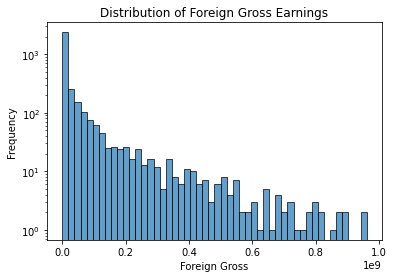

count    3.387000e+03
mean     5.248329e+07
std      1.100461e+08
min      6.000000e+02
25%      1.160000e+07
50%      1.870000e+07
75%      2.915000e+07
max      9.605000e+08
Name: foreign_gross, dtype: float64


In [16]:
# Plot the distribution of foreign_gross
plt.hist(movie_gross_df['foreign_gross'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Foreign Gross Earnings')
plt.xlabel('Foreign Gross')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Print summary statistics
print(movie_gross_df['foreign_gross'].describe())

Replacing the missing values in the foreign_gross column with the median does not alter the overall distribution of the data, thus preserving its accuracy.

In [17]:
# checking for duplicates
movie_gross_duplicates = movie_gross_df.duplicated().sum()
movie_gross_duplicates

0

This shows that there are no duplicates

In [18]:
# rechecking for null values after cleaning
movie_gross_df.isnull().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

### 2.2.2 DATA CLEANING SQL

#### MOVIE_RATINGS DATAFRAME

In [19]:
# sumary information of the dataframe
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [20]:
# summary statistics of the dataframe
movie_ratings_df.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [21]:
# checking the size of the data 
movie_ratings_df.shape

(73856, 3)

In [22]:
# checking for duplicates
movie_ratings_df_duplicated = movie_ratings_df.duplicated().sum()
movie_ratings_df_duplicated

0

In [23]:
# checking the movie ratings null values
movie_ratings_df.isnull().sum()

movie_id         0
averagerating    0
numvotes         0
dtype: int64

This dataframe has zero null values hence does not require cleaning, therefore essential for analysis

#### MOVIE_BASICS DATAFRAME

In [24]:
# summary information
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [25]:
# summary statistics
movie_basics_df.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [26]:
# checking size of the dataset
movie_basics_df.shape

(146144, 6)

In [27]:
# checking for duplicates
movie_basics_df_duplicated = movie_basics_df.duplicated().sum()
movie_basics_df_duplicated

0

In [28]:
# checking movie basics null values
movie_basics_df.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [29]:
# checking for percentage of null values
(movie_basics_df.isnull().sum()/len(movie_basics_df))*100

movie_id            0.000000
primary_title       0.000000
original_title      0.014369
start_year          0.000000
runtime_minutes    21.717621
genres              3.700460
dtype: float64

1. The percentage of null values in the original_title and genres columns is low, so dropping the rows with these null values will not significantly impact the dataset.
2. Therefore the column runtime_minutes requires data cleaning

In [30]:
# dropping rows with null in the columns original_title and genres
movie_basics_df = movie_basics_df.dropna(subset=['original_title', 'genres'])

In [31]:
# filling in missing values with the median
movie_basics_df['runtime_minutes'] = movie_basics_df['runtime_minutes'].fillna(movie_basics_df['runtime_minutes'].median())

In [32]:
# rechecking movie basics null values
movie_basics_df.isnull().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

In [33]:
movie_basics_df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [34]:
movie_ratings_df.columns

Index(['movie_id', 'averagerating', 'numvotes'], dtype='object')

In [35]:
movie_gross_df.columns


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [36]:
movie_gross_df['year']

0       2010
1       2010
2       2010
3       2010
4       2010
        ... 
3382    2018
3383    2018
3384    2018
3385    2018
3386    2018
Name: year, Length: 3387, dtype: int64

### Merge the DataFrames

In [37]:
# Merge movie_ratings_df with movie_basics_df on 'movie_id'
merged_df = pd.merge(movie_ratings_df, movie_basics_df, on='movie_id', how='inner')
merged_df

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"
...,...,...,...,...,...,...,...,...
73047,tt9805820,8.1,25,Caisa,Caisa,2018,84.0,Documentary
73048,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi"
73049,tt9851050,4.7,14,Sisters,Sisters,2019,87.0,"Action,Drama"
73050,tt9886934,7.0,5,The Projectionist,The Projectionist,2019,81.0,Documentary


In [38]:
final_merged_df = pd.merge(merged_df, movie_gross_df, left_on='primary_title', right_on='title', how='inner')
final_merged_df

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",The Legend of Hercules,LG/S,18800000.0,42400000.0,2014
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,Baggage Claim,FoxS,21600000.0,887000.0,2013
2,tt1181840,7.0,5494,Jack and the Cuckoo-Clock Heart,Jack et la mécanique du coeur,2013,94.0,"Adventure,Animation,Drama",Jack and the Cuckoo-Clock Heart,Shout!,1400000.0,3400000.0,2014
3,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",Moneyball,Sony,75600000.0,34600000.0,2011
4,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",Hereafter,WB,32700000.0,72500000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,tt3399916,6.3,4185,The Dead Lands,The Dead Lands,2014,107.0,"Action,Adventure",The Dead Lands,Magn.,5200.0,18700000.0,2015
3016,tt3616916,6.7,28167,The Wave,Bølgen,2015,105.0,"Action,Drama,Thriller",The Wave,Magn.,177000.0,18700000.0,2016
3017,tt3748512,7.4,4977,Hitchcock/Truffaut,Hitchcock/Truffaut,2015,79.0,Documentary,Hitchcock/Truffaut,Cohen,260000.0,18700000.0,2015
3018,tt7008872,7.0,18768,Boy Erased,Boy Erased,2018,115.0,"Biography,Drama",Boy Erased,Focus,6800000.0,5000000.0,2018


After merging, the columns primary_title, original_title, and title contain equivalent values. Therefore, we will drop the primary_title and original_title columns

In [39]:
# Drop the 'primary_title' and 'original_title' columns
final_merged_df.drop(columns=['primary_title', 'original_title'], inplace=True)

In [40]:
final_merged_df

,movie_id,averagerating,numvotes,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
0,tt1043726,4.2,50352,2014,99.0,"Action,Adventure,Fantasy",The Legend of Hercules,LG/S,18800000.0,42400000.0,2014
1,tt1171222,5.1,8296,2013,96.0,Comedy,Baggage Claim,FoxS,21600000.0,887000.0,2013
2,tt1181840,7.0,5494,2013,94.0,"Adventure,Animation,Drama",Jack and the Cuckoo-Clock Heart,Shout!,1400000.0,3400000.0,2014
3,tt1210166,7.6,326657,2011,133.0,"Biography,Drama,Sport",Moneyball,Sony,75600000.0,34600000.0,2011
4,tt1212419,6.5,87288,2010,129.0,"Drama,Fantasy,Romance",Hereafter,WB,32700000.0,72500000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...
3015,tt3399916,6.3,4185,2014,107.0,"Action,Adventure",The Dead Lands,Magn.,5200.0,18700000.0,2015
3016,tt3616916,6.7,28167,2015,105.0,"Action,Drama,Thriller",The Wave,Magn.,177000.0,18700000.0,2016
3017,tt3748512,7.4,4977,2015,79.0,Documentary,Hitchcock/Truffaut,Cohen,260000.0,18700000.0,2015
3018,tt7008872,7.0,18768,2018,115.0,"Biography,Drama",Boy Erased,Focus,6800000.0,5000000.0,2018


In [41]:
final_merged_df.columns

Index(['movie_id', 'averagerating', 'numvotes', 'start_year',
       'runtime_minutes', 'genres', 'title', 'studio', 'domestic_gross',
       'foreign_gross', 'year'],
      dtype='object')

### Save the cleaned data back to CSV

In [42]:
# Save cleaned DataFrames
movie_gross_df.to_csv('cleaned_movie_gross_df', index=False)
movie_basics_df.to_csv('cleaned_movie_basics_df', index=False)
movie_ratings_df.to_csv('cleaned_movie_ratings_df', index=False)
final_merged_df.to_csv('cleaned_final_merged_df', index=False)